## Code for simulations

In the next cells, there will be the code that we used for the simulations. A few counterintuitive choices have been made in order to extract as much performance as possible. The first is the removal of every numpy array. As we were not making any use of the vector operations of numpy but just accessing elements, those arrays were slower than lists. We did not save the energy (and the magnetizations) at every instant but just a running average, and we did not normalize the averages in order not to induce numerical instability (sums are very delicate in this regard, but the energy is an int and python int have no upper limit, so they are safe from this point of view).
We also ran the simulation on multiple processes in order to make python use all the cores of the cpu. The speed-up in this case was almost linear with the number of cores used.
We also did not run the code on Cpython but on PyPy, a JIT compiler for python. This allowed us to get a speed-up of about 8x.

In [2]:
import json
import math
import platform
import random
import time

# we set the seed only once for reproducibility
random.seed(2212)


def energy_nn(sigma, J, L) -> int:
    """This function computes the total energy of the configuration. It iterates over the whole lattice, and it is in practice used only once as there is a faster way to update energies.
    ----------
    sigma: the configuration of the lattice,
    J: the coupling constant,
    L: the size of the side of the lattice,
    """
    en = 0
    for i in range(L):
        for j in range(L):
            if sigma[i][j] == sigma[i][(j + 1) % L]: en -= J
            if sigma[i][j] == sigma[(i + 1) % L][j]: en -= J
    return en


def delta_energy_nn(sigma, J, i, j, new_q, L) -> int:
    """This function computes the difference in energy if one were to change a single spin. It is used in every step of the metropolis algorithm. It only looks at the neighbors of the flipped spin.
    ----------
    sigma: the configuration of the lattice,
    J: the coupling constant,
    new_q: the new spin state,
    i, j: the coordinates of the spin to be flipped,
    L: the size of the side of the lattice,
    """

    neighs = [(i, (j + 1) % L), (i, (j - 1) % L), ((i + 1) % L, j), ((i - 1) % L, j)]
    delta_en = 0
    for x, y in neighs:
        if sigma[i][j] == sigma[x][y]:
            delta_en += J
        if new_q == sigma[x][y]:
            delta_en -= J
    return delta_en


def propose_flip(sigma, J, L, N, q) -> (int, int, int):
    """This function proposes a spin flip. It is used in every step of the metropolis algorithm. It returns the coordinates of the spin to be flipped and the new spin value. It is guaranteed that the new spin value is different from the old one.
    ----------
    sigma: the configuration of the lattice,
    J: the coupling constant,
    L: the size of the side of the lattice,
    q: the number of possible spin states,
    N: the size of the lattice,
    """
    index = random.randint(0, N - 1)
    index1, index2 = index // L, index % L

    x = random.randint(0, q - 1)
    while x == sigma[index1][index2]:
        x = random.randint(0, q - 1)
    return index1, index2, x


def metropolis(delta_en, t) -> bool:
    """This function computes the acceptance probability and then decides whether to accept the flip or not by generating a random number.
    ----------
    delta_en: the difference in energy between the new and the old configuration,
    t: the temperature,
    """
    if delta_en < 0:
        return True
    if random.uniform(0, 1) < math.exp(- delta_en / t):
        return True
    return False


def bincount(x, q, double=True) -> list:
    """Replaces np.bincount. It counts the number of appearences of each integer between 0 and q-1 in the list x. Performance on this is not critical as it is run only at the beginning of each simulation and then the number of spins of each type is updated at every step.
    ----------
    x: the list to be counted,
    q: the number of possible spin states,
    double: whether x is a lattice or a list of spins,"""

    # flatten double list
    if double:
        flattened = []
        for sublist in x:
            for item in sublist:
                flattened.append(item)
        x = flattened
    # count appearences of integers between 0 and q-1 (error raised if q is wrong)
    counts = [0] * q
    for i in x:
        counts[i] += 1
    return counts

In [3]:
def MCMC(L, q, t, nstep, burnin, J=1):
    """This function runs the Metropolis algorithm for a given number of steps. It returns the average magnetization and the average energy.
    ----------
    L: the size of the side of the lattice,
    q: the number of possible spin states,
    t: the temperature,
    nstep: the number of steps to be run,
    burnin: the number of steps to be run before starting to collect data,
    J: the coupling constant,
    """

    # random initial configuration
    N = L ** 2
    sigma = [[random.randint(0, q - 1) for _1 in range(L)] for _2 in range(L)]

    # initial energy
    en = energy_nn(sigma, J, L)

    # run burnin steps to reach stationarity
    for istep in range(burnin):
        # propose random flip
        ind1, ind2, q_new = propose_flip(sigma, J, L, N, q)
        # compute energy difference
        delta_en = delta_energy_nn(sigma, J, ind1, ind2, q_new, L)
        # metropolis update rule
        if metropolis(delta_en, t):
            # update state
            q_old = sigma[ind1][ind2]
            sigma[ind1][ind2] = q_new
            # update energy
            en += delta_en

    # initialize magnetization averaging
    magnetization_state = bincount(sigma, q)
    max_magnetization_avg = 0

    # initialize energy averaging
    energy_avg = 0

    # main loop
    for istep in range(nstep):
        # propose random flip
        ind1, ind2, q_new = propose_flip(sigma, J, L, N, q)
        # compute energy difference
        delta_en = delta_energy_nn(sigma, J, ind1, ind2, q_new, L)

        # metropolis update rule
        if metropolis(delta_en, t):
            # update state
            q_old = sigma[ind1][ind2]
            sigma[ind1][ind2] = q_new

            # update energy
            en += delta_en
            # update magnetization history
            magnetization_state[q_old] -= 1
            magnetization_state[q_new] += 1

        # update averages
        max_magnetization_avg += max(magnetization_state)
        energy_avg += en

    # normalize and return averages
    return energy_avg / nstep, max_magnetization_avg / nstep / N

In [4]:
# utility functions to decide range of temperatures to test against and generate the list

def critical_Temperature(q, J=1):
    return J / math.log(1 + math.sqrt(q))


# values that we changed to run different tests
n2 = 1
n1 = 3
dt = 0.005


def arange(start, stop, step):
    """Replaces numpy.arange"""
    result = []
    eps = 0.001
    current = start
    while current < stop - eps:
        result.append(current)
        current += step
    return result


def get_temps(q, J=1, n1=n1, n2=n2, dt=dt, zero=0.4, infinity=3.0):
    """Generates 3 lists, one for low temperature with few intervals, one for temperatures around the critical T with many intervals and one for high temperatures with few intervals.
    ----------
    q: the number of possible spin states,
    J: the coupling constant,
    n1: the number of intervals around the critical temperature,
    n2: the number of intervals for low and high temperatures,
    dt: the size of the intervals around the critical temperature,
    zero: the lower bound of the low temperature interval,
    infinity: the upper bound of the high temperature interval,
    """

    crit = critical_Temperature(q, J)
    crit = round(crit, 4)

    low = crit - n1 * dt
    high = crit + n1 * dt

    # compute the 3 lists
    core = arange(low, high, dt)
    out1 = arange(zero, low, (low - zero) / n2)
    out2 = arange(high, infinity, (infinity - high) / (n2 + 1))

    # cut one of the lists to avoid overlaps
    core = list(core)
    out1 = list(out1)[:-1]
    out2 = list(out2)

    # round to 4 decimals
    for arr in [core, out1, out2]:
        for i, x in enumerate(arr):
            arr[i] = round(x, 4)

    return out1, core, out2

In [5]:
def simulate(L, q):
    """This function runs a full simulation at all the temperatures given q and L
    ----------
    L: the size of the side of the lattice,
    q: the number of possible spin states,
    ----------
    returns a list of the temperatures, a list of the average energy and a list of the average magnetization for each temperature
    """
    avg_en = []
    avg_mag = []

    temps_triple = get_temps(q)

    ordered_temps = []

    steps = (4 * 10 ** 7, 10 ** 8, 4 * 10 ** 7)
    burnin = (4 * 10 ** 7, 10 ** 8, 4 * 10 ** 7)

    for temps, step, burn in zip(temps_triple, steps, burnin):
        for t in temps:
            tempo = time.time()
            ordered_temps.append(t)
            if abs(t - critical_Temperature(q)) < 0.05:
                print(f"Starting simulation for {q=} {L=} {t=} with step={4 * 10 ** 8} and burnin={2 * 10 ** 8}")
                en, mag = MCMC(L, q, t, 5 * 10 ** 8, 2 * 10 ** 8)
            else:
                print(f"Starting simulation for {q=} {L=} {t=} with step={step} and burnin={burn}")
                en, mag = MCMC(L, q, t, step, burn)
            avg_en.append(en)
            avg_mag.append(mag)
            print(f"Elapsed time: {time.time() - tempo}")

    return ordered_temps, avg_en, avg_mag


def simulate_save(inp):
    """This function wraps the previous simulation, computes the specific heats and saves the results in a json file
    ----------
    inp: a tuple containing (q, L)"""

    # the reason for the tuple is to easily run a multiprocess Pool
    q, L = inp
    tempo = time.time()

    # due to the length of the simulation we log some information to keep track of the progress
    print(f"Simulating {q=} {L=}")
    temps, avg_en, avg_mag = simulate(L, q)
    print(f"Elapsed time: {time.time() - tempo}")

    # compute specific heat by finite differences at the midpoints of the temperature intervals
    spec_heat = [(avg_en[i + 1] - avg_en[i]) / (temps[i + 1] - temps[i]) for i in range(0, len(temps) - 1)]
    spec_heat_temps = [(temps[i + 1] + temps[i]) / 2 for i in range(0, len(temps) - 1)]

    for i, x in enumerate(spec_heat_temps):
        spec_heat_temps[i] = round(x, 3)

    with open(f"simulation_{q=}_{L=}.json", "w") as file:
        json.dump({"temps": temps, "avg_en": avg_en, "avg_mag": avg_mag,
                   "spec_heat": spec_heat, "spec_heat_temps": spec_heat_temps}, file)


In [6]:
# Warning: this cell takes a long time to run
import multiprocessing as mp

# this list was changed during the simulations to run different tests
qs_Ls = [
    (4, 50),
    (5, 50),
]

# the Pool size depends on the CPU
with mp.Pool(4) as p:
    print(p.map(simulate_save, qs_Ls))

Simulating q=4 L=50Simulating q=5 L=50

Starting simulation for q=4 L=50 t=0.8952 with step=400000000 and burnin=200000000Starting simulation for q=5 L=50 t=0.8365 with step=400000000 and burnin=200000000



KeyboardInterrupt: 

## Results

After running all the simulations we are ready to show some results. We can start by plotting the energy against the temperature for the different values of $q$ fixing a $L$. We are going to load the results from a json and not run the cell above as it takes hours.

In [15]:
from dataclasses import dataclass
import os
import matplotlib.pyplot as plt


def load(q, L):
    with open(os.path.join("results", f"simulation_{q=}_{L=}.json")) as f:  # change this
        d = json.load(f)
    for key in d.keys():
        d[key] = d[key][1:]
    return d.values()


@dataclass
class Experiment:
    temps: list
    avg_en: list
    avg_mag: list
    spec_heat: list
    spec_heat_temps: list


exps: dict[tuple[int, int]: Experiment] = {}

In [26]:
qs = [2, 4, 5, 8]
Ls = [10, 20, 30, 50]
for q in qs:
    for L in Ls:
        try:
            exps[q, L] = Experiment(*load(q, L))
        except FileNotFoundError:
            pass

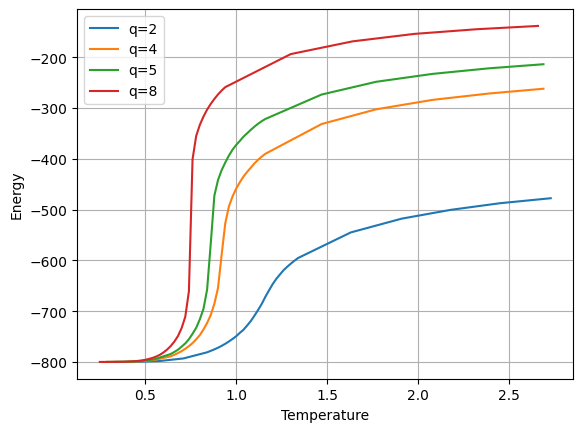

In [29]:
L = 20
for q in qs:
    plt.plot(exps[q, L].temps, exps[q, L].avg_en, label=f"q={q}")

plt.legend()
plt.xlabel("Temperature")
plt.ylabel("Energy")
plt.grid()

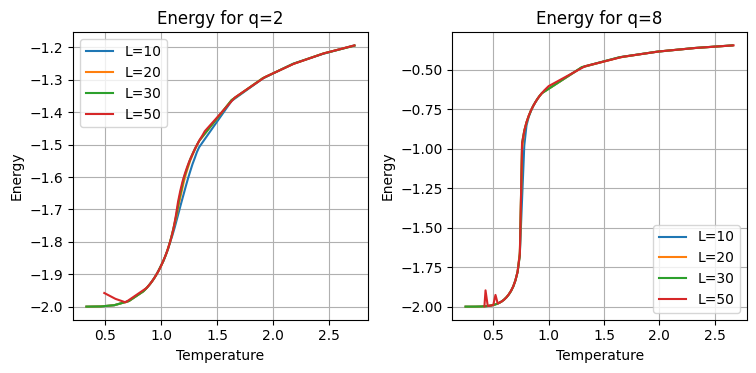

In [42]:
import numpy as np

q_1 = [2, 8]
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
fig.tight_layout(pad=3.0)
for i, q in enumerate(q_1):
    for L in Ls:
        # We divide by L^2 in order to have all the energies on the same order of magnitude

        ax[i].plot(exps[q, L].temps, np.array(exps[q, L].avg_en) / L ** 2, label=f"L={L}")

    ax[i].legend()
    ax[i].set_xlabel("Temperature")
    ax[i].set_ylabel("Energy")
    ax[i].set_title(f"Energy for q={q}")
    ax[i].grid()

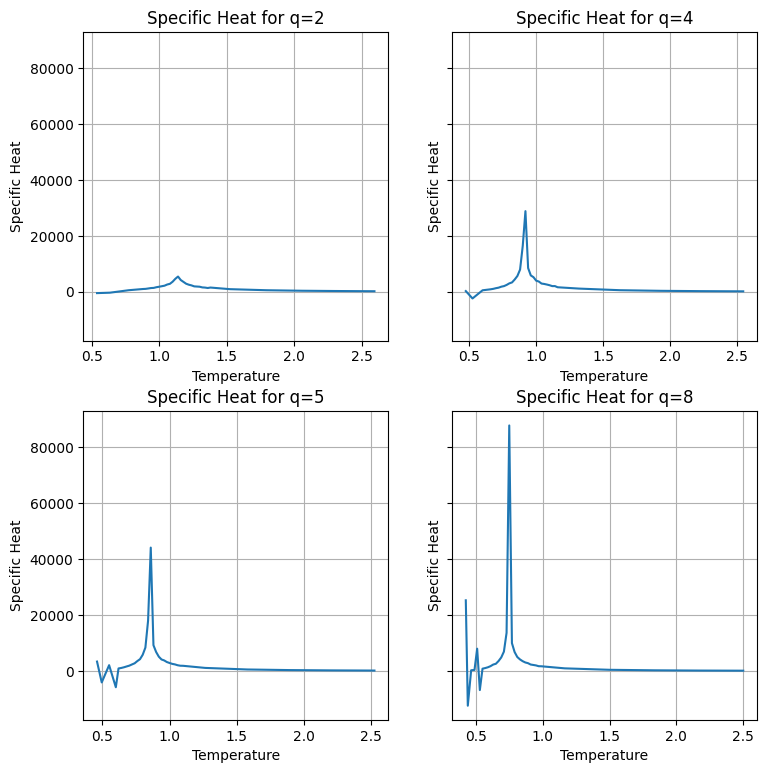

In [49]:
# plot the specific heat the same way for all the qs in a grid setting L constant to 50
L = 50
fig, ax = plt.subplots(2, 2, figsize=(8, 8), sharey=True)
fig.tight_layout(pad=3.0)
for i, q in enumerate(qs):
    ax[i // 2, i % 2].plot(exps[q, L].spec_heat_temps, exps[q, L].spec_heat, label=f"L={L}")

    # ax[i // 2, i % 2].legend()
    ax[i // 2, i % 2].set_xlabel("Temperature")
    ax[i // 2, i % 2].set_ylabel("Specific Heat")
    ax[i // 2, i % 2].set_title(f"Specific Heat for q={q}")
    ax[i // 2, i % 2].grid()

# make all the subplots share the same y axis
# for i in range(2):
#     for j in range(2):
#         for k in range(2):
#             ax[i, j].get_shared_y_axes().join(ax[i, j], ax[i, k])


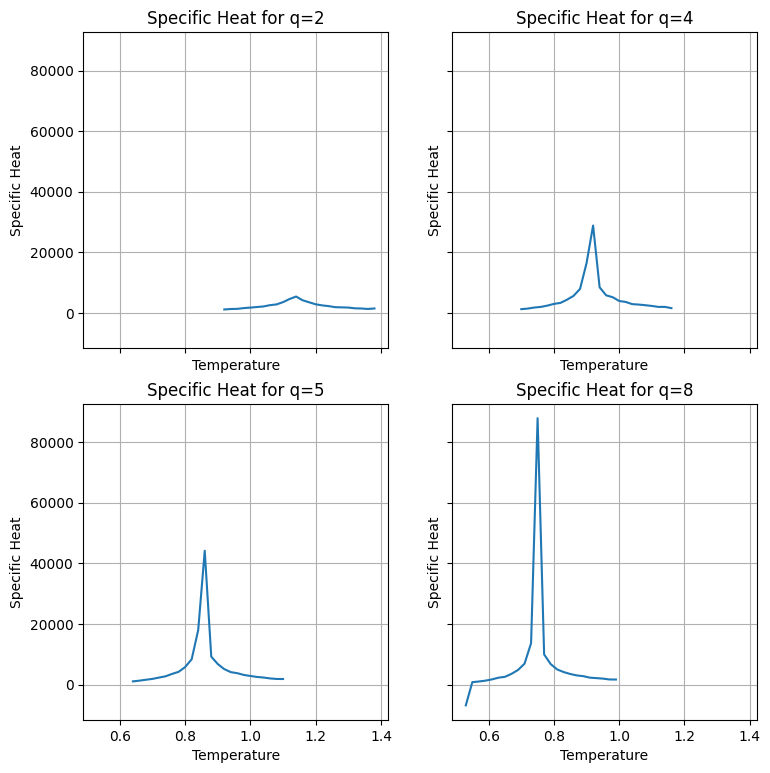

In [55]:
# now do the same for the specific heat but zoom into the 20 centered values of the list
L = 50
fig, ax = plt.subplots(2, 2, figsize=(8, 8), sharey=True, sharex=True)
fig.tight_layout(pad=3.0)
for i, q in enumerate(qs):
    ax[i // 2, i % 2].plot(exps[q, L].spec_heat_temps[5:-5], exps[q, L].spec_heat[5:-5], label=f"L={L}")

    # ax[i // 2, i % 2].legend()
    ax[i // 2, i % 2].set_xlabel("Temperature")
    ax[i // 2, i % 2].set_ylabel("Specific Heat")
    ax[i // 2, i % 2].set_title(f"Specific Heat for q={q}")
    ax[i // 2, i % 2].grid()

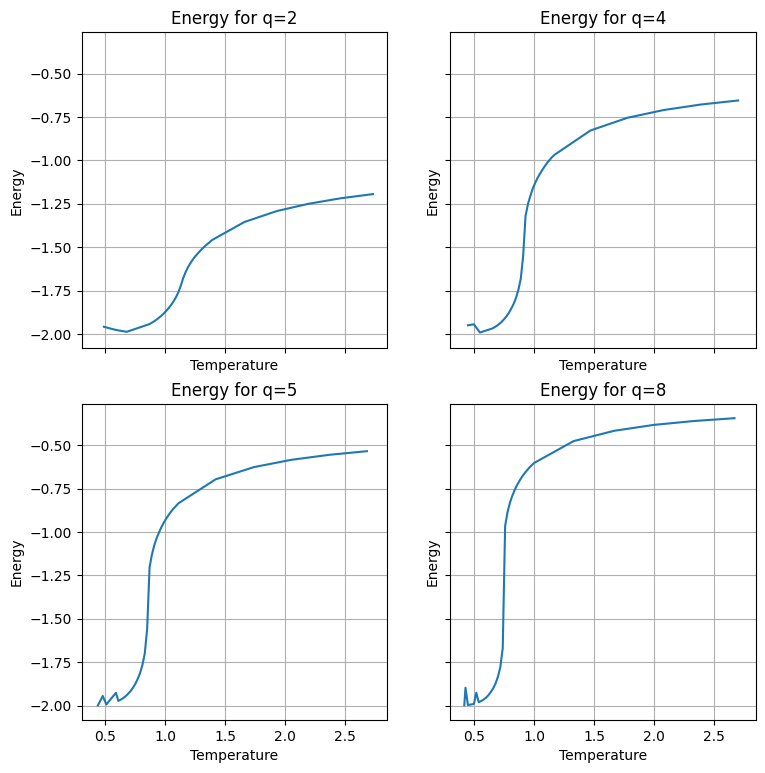

In [57]:
# plot the energy the same way you did for the specific heat in a grid setting L constant to 50
L = 50
fig, ax = plt.subplots(2, 2, figsize=(8, 8), sharey=True, sharex=True)
fig.tight_layout(pad=3.0)
for i, q in enumerate(qs):
    ax[i // 2, i % 2].plot(exps[q, L].temps, np.array(exps[q, L].avg_en) / L ** 2, label=f"L={L}")

    # ax[i // 2, i % 2].legend()
    ax[i // 2, i % 2].set_xlabel("Temperature")
    ax[i // 2, i % 2].set_ylabel("Energy")
    ax[i // 2, i % 2].set_title(f"Energy for q={q}")
    ax[i // 2, i % 2].grid()
